In [1]:
import os, shutil, glob
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # if we have only one GPU, otherwise "0, 1, etc"
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7077709596332106516
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3434391900505562652
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 4537527831701911732
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 80216064
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3677925296405345546
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:08:00.0, compute capability: 6.1"
]


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import pandas as pd
from PIL import Image
import random
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc, roc_auc_score

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# TensorFlow and Keras
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.regularizers import l2
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import utils 

# import keras
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import metrics
from tensorflow.keras import optimizers 

print(tf.__version__)

#scratch-shared/maris/tests/labels.csv
#scratch-shared/maris/tests/MiCoPh_Image_0_255
#scratch-shared/maris/tests/MiSyHo_Image_0_255

2.1.0


## Load the images

In [3]:
basedir1 = input("Enter first directory name of images: ") # e.g.  /home/jovyan/scratch-shared/maris/tests/MiCoPh_Image_0_255

Enter first directory name of images:  /home/jovyan/scratch-shared/maris/tests/MiCoPh_Image_0_255


In [4]:
print(len(os.listdir(basedir1)))

12301


In [5]:
basedir2 = input("Enter second directory name of images: ") # e.g. /home/jovyan/scratch-shared/maris/tests/MiSyHo_Image_0_255

Enter second directory name of images:  /home/jovyan/scratch-shared/maris/tests/MiSyHo_Image_0_255


In [6]:
print(len(os.listdir(basedir2)))

12301


## Preprocessing

In [7]:
df=pd.read_csv('/home/jovyan/scratch-shared/maris/tests/labels.csv', sep=';')
df.columns = ['nr','plate','well',
                     'site','type','compoundname','target','concentration']
df.fillna("NotKnown", inplace = True)

df["target"] = df["target"].str.replace(' ', '') #remove spaces
df["target"] = df["target"].str.replace('c-Kit', 'cKit') #
df["target"] = df["target"].str.replace('GSK-3', 'GSK3') #
df["target"] = df["target"].str.replace('VEGFR', 'VEGrFR') #so that string EGFR is not in VEGFR
df['target'] = np.where((df['type'] == 'control'), df['type'] , df['target'])

df["filename"] = df["nr"].astype(str) + ".png"

df

,nr,plate,well,site,type,compoundname,target,concentration,filename
0,0,P009063,B02,1,compound,CBK013405,EGFR,10,0.png
1,1,P009063,B02,2,compound,CBK013405,EGFR,10,1.png
2,2,P009063,B02,3,compound,CBK013405,EGFR,10,2.png
3,3,P009063,B02,4,compound,CBK013405,EGFR,10,3.png
4,4,P009063,B02,5,compound,CBK013405,EGFR,10,4.png
...,...,...,...,...,...,...,...,...,...
12295,12295,P009083,G11,5,compound,CBK293913C,Rho,4,12295.png
12296,12296,P009083,G11,6,compound,CBK293913C,Rho,4,12296.png
12297,12297,P009083,G11,7,compound,CBK293913C,Rho,4,12297.png
12298,12298,P009083,G11,8,compound,CBK293913C,Rho,4,12298.png


In [8]:
activities = sorted(list(set(df['target']))) 
for a in activities:
    if ',' in a:
        df[a] = [1 if a == x else 0 for x in df['target']]
    else:
        df[a] = [1 if a in x else 0 for x in df['target']] # COMPOUNDS THAT HAVE SEVERAL TARGETS GET VALUE 1 FOR EACH TARGET
print(activities)

['ALK', 'AMPK', 'ATM', 'ATM/ATR', 'Akt', 'Akt,CDK,PKA', 'Akt,MEK', 'Akt,PDK-1', 'Akt,S6kinase', 'AuroraKinase', 'AuroraKinase,FGFR,Bcr-Abl,c-RET,Src', 'AuroraKinase,VEGrFR', 'BTK', 'Bcr-Abl', 'Bcr-Abl,JAK,AuroraKinase', 'Bcr-Abl,VEGrFR,FGFR,PDGFR,Flt', 'CDK', 'CDK,AuroraKinase', 'CHK', 'Chk', 'DNA-PK,PI3K', 'DNA-PK,PI3K,mTOR', 'DNA-PK,mTOR,PDGF', 'DUB,Bcr-Abl', 'EGFR', 'EGFR,Flt,VEGrFR,HER2', 'EGFR,HER2', 'EGFR,mTOR', 'ERK', 'FAK', 'FGFR', 'FGFR,VEGrFR', 'FLT3', 'Flt', 'Flt,AuroraKinase,VEGrFR', 'Flt,Bcr-Abl,AuroraKinase', 'Flt,FGFR,PDGFR,VEGrFR,cKit', 'Flt,JAK,c-RET', 'FreeBase', 'GSK3', 'HDAC,EGFR,HER2', 'HDAC,PI3K', 'HER2', 'HER2,EGFR', 'IA/ASB/IKK', 'IGF-1,ALK', 'IGF-1R', 'IKK', 'I¦ÊB/IKK', 'JAK', 'JAK,EGFR', 'JNK', 'LRRK2', 'MEK', 'NotKnown', 'Others', 'PAK', 'PDGFR', 'PDGFR,VEGrFR', 'PDGFR,cKit,Bcr-Abl', 'PDK-1', 'PDK-1,IKK', 'PI3K', 'PI3K,DNA-PK', 'PI3K,PKC,Src,Sirtuin', 'PI3K,VEGrFR', 'PI3K,mTOR', 'PI3K/Akt/mTOR', 'PKC', 'PLK', 'Pim', 'ProductCategoriesPI3K/Akt/mTORPI3KPI3K', '

In [9]:
nrclasses = len(activities)
nrclasses

115

In [10]:
df = df[df.NotKnown != 1]
df = df.drop(columns='NotKnown')
activities.remove('NotKnown')
df

,nr,plate,well,site,type,compoundname,target,concentration,filename,ALK,...,c-Myc,"cKit,FGFR,Flt,VEGrFR,PDGFR","cKit,PDGFR,FGFR,FAK","cKit,Raf,VEGrFR","cKit,VEGrFR",control,mTOR,"mTOR,PI3K","mTOR,PI3K,Akt",p38MAPK
0,0,P009063,B02,1,compound,CBK013405,EGFR,10,0.png,0,...,0,0,0,0,0,0,0,0,0,0
1,1,P009063,B02,2,compound,CBK013405,EGFR,10,1.png,0,...,0,0,0,0,0,0,0,0,0,0
2,2,P009063,B02,3,compound,CBK013405,EGFR,10,2.png,0,...,0,0,0,0,0,0,0,0,0,0
3,3,P009063,B02,4,compound,CBK013405,EGFR,10,3.png,0,...,0,0,0,0,0,0,0,0,0,0
4,4,P009063,B02,5,compound,CBK013405,EGFR,10,4.png,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12295,12295,P009083,G11,5,compound,CBK293913C,Rho,4,12295.png,0,...,0,0,0,0,0,0,0,0,0,0
12296,12296,P009083,G11,6,compound,CBK293913C,Rho,4,12296.png,0,...,0,0,0,0,0,0,0,0,0,0
12297,12297,P009083,G11,7,compound,CBK293913C,Rho,4,12297.png,0,...,0,0,0,0,0,0,0,0,0,0
12298,12298,P009083,G11,8,compound,CBK293913C,Rho,4,12298.png,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
nrclasses = len(activities)
nrclasses

114

In [12]:
df['plate_well'] = df['plate'] + df['well']
welllist = sorted(list(set(df['plate_well'])))
print(len(welllist))
print(welllist[0:5])

def partitions (list_in, n):
    random.seed(1)
    random.shuffle(list_in)
    return [list_in[i::n] for i in range(n)]

chunks = partitions(welllist, 5) #split the dataset in 5 folds excluding 20% of images (a better way to validate would be excluding 20% of wells)
#print (chunks[0])
len(chunks)
df1=df[~df['plate_well'].isin(chunks[0])]
df2=df[df['plate_well'].isin(chunks[0])]
print(len(set(df1['nr'])))
print(len(df2))


1253
['P009063B02', 'P009063B03', 'P009063B04', 'P009063B05', 'P009063B06']
9738
2499


In [13]:
df1=df1.sort_values(by="filename") 
df1=df1.reset_index()

df2=df2.sort_values(by="filename")
df2=df2.reset_index()
df2.head()

,index,nr,plate,well,site,type,compoundname,target,concentration,filename,...,"cKit,FGFR,Flt,VEGrFR,PDGFR","cKit,PDGFR,FGFR,FAK","cKit,Raf,VEGrFR","cKit,VEGrFR",control,mTOR,"mTOR,PI3K","mTOR,PI3K,Akt",p38MAPK,plate_well
0,10014,10014,P009079,F08,1,control,DMSO,control,10,10014.png,...,0,0,0,0,1,0,0,0,0,P009079F08
1,10015,10015,P009079,F08,2,control,DMSO,control,10,10015.png,...,0,0,0,0,1,0,0,0,0,P009079F08
2,10016,10016,P009079,F08,3,control,DMSO,control,10,10016.png,...,0,0,0,0,1,0,0,0,0,P009079F08
3,10017,10017,P009079,F08,4,control,DMSO,control,10,10017.png,...,0,0,0,0,1,0,0,0,0,P009079F08
4,10018,10018,P009079,F08,5,control,DMSO,control,10,10018.png,...,0,0,0,0,1,0,0,0,0,P009079F08


## Calculate class weights

In [14]:
def calculating_class_weights(y_true):
    from sklearn.utils.class_weight import compute_class_weight
    number_dim = np.shape(y_true)[1]
    weights = np.empty([number_dim, 2])
    for i in range(number_dim):
        weights[i] = compute_class_weight('balanced', [0.,1.], y_true[:, i])
    return weights

def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss

def weighted_loss(y_true, y_pred):
    return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)

import tensorflow.keras.losses
keras.losses.weighted_loss = weighted_loss

class_weights = calculating_class_weights(df[activities].values)
print (class_weights)

scaling = 0.5 # some number between 0 and 1; if 0, no scaling is performed
class_weights_scaled = class_weights**scaling
print (class_weights_scaled) 

[[  0.50557759  45.32222222]
 [  0.50445214  56.65277778]
 [  0.50670807  37.76851852]
 [  0.50445214  56.65277778]
 [  0.51803404  14.36267606]
 [  0.50110565 226.61111111]
 [  0.50110565 226.61111111]
 [  0.50110565 226.61111111]
 [  0.50110565 226.61111111]
 [  0.52645844   9.94878049]
 [  0.50110565 226.61111111]
 [  0.50110565 226.61111111]
 [  0.50333169  75.53703704]
 [  0.52041337  12.746875  ]
 [  0.50110565 226.61111111]
 [  0.50110565 226.61111111]
 [  0.52523822  10.40561224]
 [  0.50110565 226.61111111]
 [  0.50110565 226.61111111]
 [  0.50445214  56.65277778]
 [  0.50110565 226.61111111]
 [  0.50110565 226.61111111]
 [  0.50110565 226.61111111]
 [  0.50110565 226.61111111]
 [  0.5402649    6.70888158]
 [  0.50110565 226.61111111]
 [  0.50759084  33.43442623]
 [  0.50110565 226.61111111]
 [  0.50110565 226.61111111]
 [  0.50445214  56.65277778]
 [  0.51476527  17.43162393]
 [  0.50110565 226.61111111]
 [  0.50110565 226.61111111]
 [  0.5171146   15.10740741]
 [  0.50110565

## ImageDataGenerator and FlowFromDataframe

In [15]:
datagen= ImageDataGenerator(rescale=(1./255), horizontal_flip=True, vertical_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255.)

classes = None
#target_size = 270, 270
target_size = 224, 224 #input size for MobileNet and MobileNetV2
x_col = 'filename'
y_col = activities

train_generator1=datagen.flow_from_dataframe(
dataframe=df1,
directory=basedir1,
x_col="filename",
has_ext=True,
y_col=y_col,
batch_size=32,
seed=42,
shuffle=True,
class_mode="other",
classes = classes,
interpolation = "lanczos",
target_size=target_size)

validation_generator1=datagen.flow_from_dataframe(
dataframe=df2,
directory=basedir1,
x_col="filename",
has_ext=True,
y_col=y_col,
batch_size=1,
seed=42,
shuffle=False,
class_mode="other",
classes=classes,
interpolation = "lanczos",
target_size=target_size)

test_generator1=datagen.flow_from_dataframe(
dataframe=df2,
directory=basedir1,
x_col="filename",
has_ext=True,
y_col=y_col,
batch_size=1,
seed=42,
shuffle=False,
class_mode="other",
interpolation = "lanczos",
target_size=target_size)

train_generator2=datagen.flow_from_dataframe(
dataframe=df1,
directory=basedir2,
x_col="filename",
has_ext=True,
y_col=y_col,
batch_size=32,
seed=42,
shuffle=True,
class_mode="other",
classes=classes,
interpolation = "lanczos",
target_size=target_size)

validation_generator2=datagen.flow_from_dataframe(
dataframe=df2,
directory=basedir2,
x_col="filename",
has_ext=True,
y_col=y_col,
batch_size=1,
seed=42,
shuffle=False,
class_mode="other",
classes=classes,
interpolation = "lanczos",
target_size=target_size)

test_generator2=datagen.flow_from_dataframe(
dataframe=df2,
directory=basedir2,
x_col="filename",
has_ext=True,
y_col=y_col,
batch_size=1,
seed=42,
shuffle=False,
class_mode="other",
interpolation = "lanczos",
target_size=target_size)

Found 9738 validated image filenames.
Found 2499 validated image filenames.
Found 2499 validated image filenames.
Found 9738 validated image filenames.
Found 2499 validated image filenames.
Found 2499 validated image filenames.


In [16]:
def doubleGenerator(generator1,generator2): #Input size of (224,224,5)
    while True:
        for (x1,y1),(x2,y2) in zip(generator1,generator2):
            yield (np.concatenate((x1,x2[:,:,:,1:]), axis=3),y1)

In [17]:
'''def doubleGenerator(generator1,generator2): #for 2 networks with 3 channels each
    while True:
        for (x1,y1),(x2,y2) in zip(generator1,generator2):
            yield ([x1,x2],y1)'''

'def doubleGenerator(generator1,generator2): #for 2 networks with 3 channels each\n    while True:\n        for (x1,y1),(x2,y2) in zip(generator1,generator2):\n            yield ([x1,x2],y1)'

## VGG16


In [18]:
model = Sequential()

model.add(Conv2D(input_shape=(224,224,5),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=4096,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=nrclasses, activation="sigmoid")) # CHANGED TO SIGMOID

ResourceExhaustedError: OOM when allocating tensor with shape[3,3,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Add] name: conv2d_11/kernel/Initializer/random_uniform/

In [19]:
'''model2 = Sequential()                 
model2.add(keras.applications.vgg16.VGG16(input_shape=(224,224,3), include_top=False, weights='imagenet'))'''

"model2 = Sequential()                 \nmodel2.add(keras.applications.vgg16.VGG16(input_shape=(224,224,3), include_top=False, weights='imagenet'))"

In [19]:
from tensorflow.keras.applications.vgg16 import VGG16


In [20]:
pre_trained_model1 = VGG16(input_shape=(224,224,3), include_top=False, weights=None)

pre_trained_model2 = VGG16(input_shape=(224,224,3), include_top=False, weights=None)

for i, layer in enumerate(pre_trained_model2.layers):
    layer._name = 'layer_' + str(i)

ResourceExhaustedError: OOM when allocating tensor with shape[3,3,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Add] name: block3_conv3/kernel/Initializer/random_uniform/

In [20]:
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.0001) 
myloss=keras.losses.binary_crossentropy
# myloss=get_weighted_loss(class_weights_scaled)
model.compile(optimizer=opt, loss=myloss, metrics=['accuracy']) #changed to binary_crossentropy

In [21]:
'''from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.001)
model2.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])'''

"from tensorflow.keras.optimizers import Adam\nopt = Adam(lr=0.001)\nmodel2.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])"

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      2944      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       295168    
__________

In [23]:
'''model2.summary()'''

'model2.summary()'

In [24]:
STEP_SIZE_TRAIN=train_generator1.n//train_generator1.batch_size
STEP_SIZE_VALID=validation_generator1.n//validation_generator1.batch_size
STEP_SIZE_TEST=test_generator1.n//test_generator1.batch_size

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

#hist = model.fit_generator(steps_per_epoch=100,generator=traindata, validation_data= testdata, validation_steps=10,epochs=100,callbacks=[checkpoint,early])

In [26]:
history = model.fit_generator(generator=doubleGenerator(train_generator1, train_generator2),
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=doubleGenerator(validation_generator1, validation_generator2),
                    validation_steps=STEP_SIZE_VALID,
                    epochs=5,
                    callbacks = [checkpoint,early]
                    )

Epoch 1/5
303/304 [============================>.] - ETA: 1s - loss: 0.1099 - acc: 0.9833
Epoch 00001: val_acc improved from -inf to 0.98764, saving model to vgg16_1.h5
304/304 [==============================] - 515s 2s/step - loss: 0.1097 - acc: 0.9833 - val_loss: 0.0577 - val_acc: 0.9876
Epoch 2/5
303/304 [============================>.] - ETA: 1s - loss: 0.0597 - acc: 0.9873
Epoch 00002: val_acc did not improve from 0.98764
304/304 [==============================] - 488s 2s/step - loss: 0.0597 - acc: 0.9873 - val_loss: 0.0580 - val_acc: 0.9876
Epoch 3/5
303/304 [============================>.] - ETA: 1s - loss: 0.0593 - acc: 0.9873
Epoch 00003: val_acc did not improve from 0.98764
304/304 [==============================] - 488s 2s/step - loss: 0.0593 - acc: 0.9873 - val_loss: 0.0577 - val_acc: 0.9876
Epoch 4/5
303/304 [============================>.] - ETA: 1s - loss: 0.0588 - acc: 0.9873
Epoch 00004: val_acc did not improve from 0.98764
304/304 [==============================] - 48

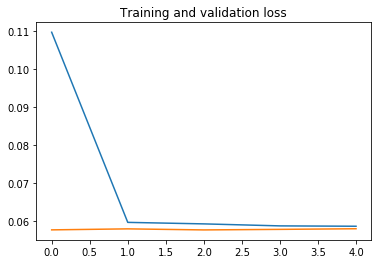

In [28]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

#Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(121)
ax1.plot(epochs, acc)
ax1.plot(epochs, val_acc)
ax1.set_title('Training and validation accuracy')

# Plot training and validation loss per epoch
ax2 = fig.add_subplot(122)
ax2.plot(epochs, loss)
ax2.plot(epochs, val_loss)
ax2.set_title('Training and validation loss')

fig.savefig('loss_VGG16_adam_lr0.0001_batch32_may14.png', dpi=300) # SAVE FIGURE

In [29]:
test_generator1.reset()
test_generator2.reset()
predictions = model.predict_generator(doubleGenerator(test_generator1, test_generator2), verbose=1, steps=test_generator1.samples/test_generator1.batch_size)

2499/2499 [==============================] - 103s 41ms/step


In [30]:
print(predictions[:,0:5])

[[0.00912512 0.00794428 0.01081811 0.00716766 0.02794332]
 [0.00853965 0.00741981 0.0101503  0.00668522 0.02660473]
 [0.00745208 0.00645457 0.00890596 0.00579443 0.02405285]
 ...
 [0.00895182 0.00779149 0.0106216  0.00702557 0.02755263]
 [0.00872816 0.00759042 0.01036496 0.00684176 0.02704301]
 [0.00813663 0.00706177 0.00969017 0.00635369 0.02567138]]


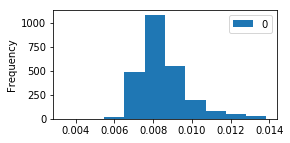

In [31]:
pd.DataFrame(predictions[:,0]).plot(kind='hist', figsize=(4, 2))

In [32]:
y = df2[activities].values
y.shape


(2499, 114)

In [33]:
auc_of_models = pd.DataFrame(columns = ['target/activity', 'roc area'])

for i in range(nrclasses):
    try:
        roc_auc = (roc_auc_score(y[:,i], predictions[:,i]))
        print("roc_auc for class '%s'" % activities[i], roc_auc)
        auc_of_models.loc[i]=(activities[i], roc_auc) 
    except:
        continue

        
auc_of_models.to_csv('rocauc_VGG16_adam_lr0.0001_batch32_may14.csv', sep=',') #SAVE ROC_AUC

roc_auc for class 'ALK':  0.517
roc_auc for class 'AMPK':  0.706
roc_auc for class 'ATM':  0.682
roc_auc for class 'ATM/ATR':  0.776
roc_auc for class 'Akt':  0.477
roc_auc for class 'Akt,PDK-1':  0.299
roc_auc for class 'Akt,S6kinase':  0.832
roc_auc for class 'AuroraKinase':  0.667
roc_auc for class 'AuroraKinase,FGFR,Bcr-Abl,c-RET,Src':  0.746
roc_auc for class 'BTK':  0.674
roc_auc for class 'Bcr-Abl':  0.406
roc_auc for class 'CDK':  0.664
roc_auc for class 'CDK,AuroraKinase':  0.935
roc_auc for class 'CHK':  0.644
roc_auc for class 'Chk':  0.832
roc_auc for class 'DNA-PK,PI3K,mTOR':  0.617
roc_auc for class 'DUB,Bcr-Abl':  0.254
roc_auc for class 'EGFR':  0.496
roc_auc for class 'EGFR,HER2':  0.324
roc_auc for class 'ERK':  0.231
roc_auc for class 'FAK':  0.619
roc_auc for class 'FGFR':  0.68
roc_auc for class 'FGFR,VEGrFR':  0.721
roc_auc for class 'Flt':  0.637
roc_auc for class 'Flt,AuroraKinase,VEGrFR':  0.953
roc_auc for class 'Flt,Bcr-Abl,AuroraKinase':  0.617
roc_auc for c

In [48]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(nrclasses):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [49]:
print (roc_auc["micro"])

0.8104027215083275


No handles with labels found to put in legend.


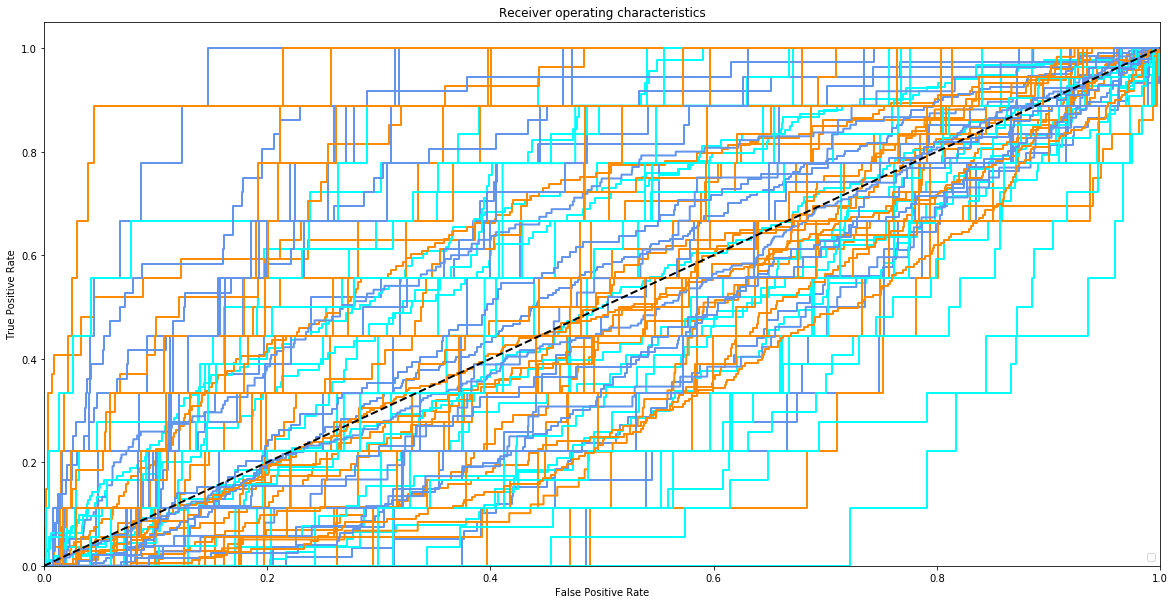

In [51]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(nrclasses)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(nrclasses):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= nrclasses

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.rcParams["figure.figsize"] = (20,10)
plt.figure()
# plt.plot(fpr["micro"], tpr["micro"],
#         label='micro-average ROC curve (area = {0:0.2f})'
#               ''.format(roc_auc["micro"]),
#         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(nrclasses), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(activities[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics')
plt.legend(loc="lower right")
plt.show()

plt.savefig('rocauc_VGG16_adam_lr0.0001_batch32_may14.png', dpi=300) # SAVE FIGURE

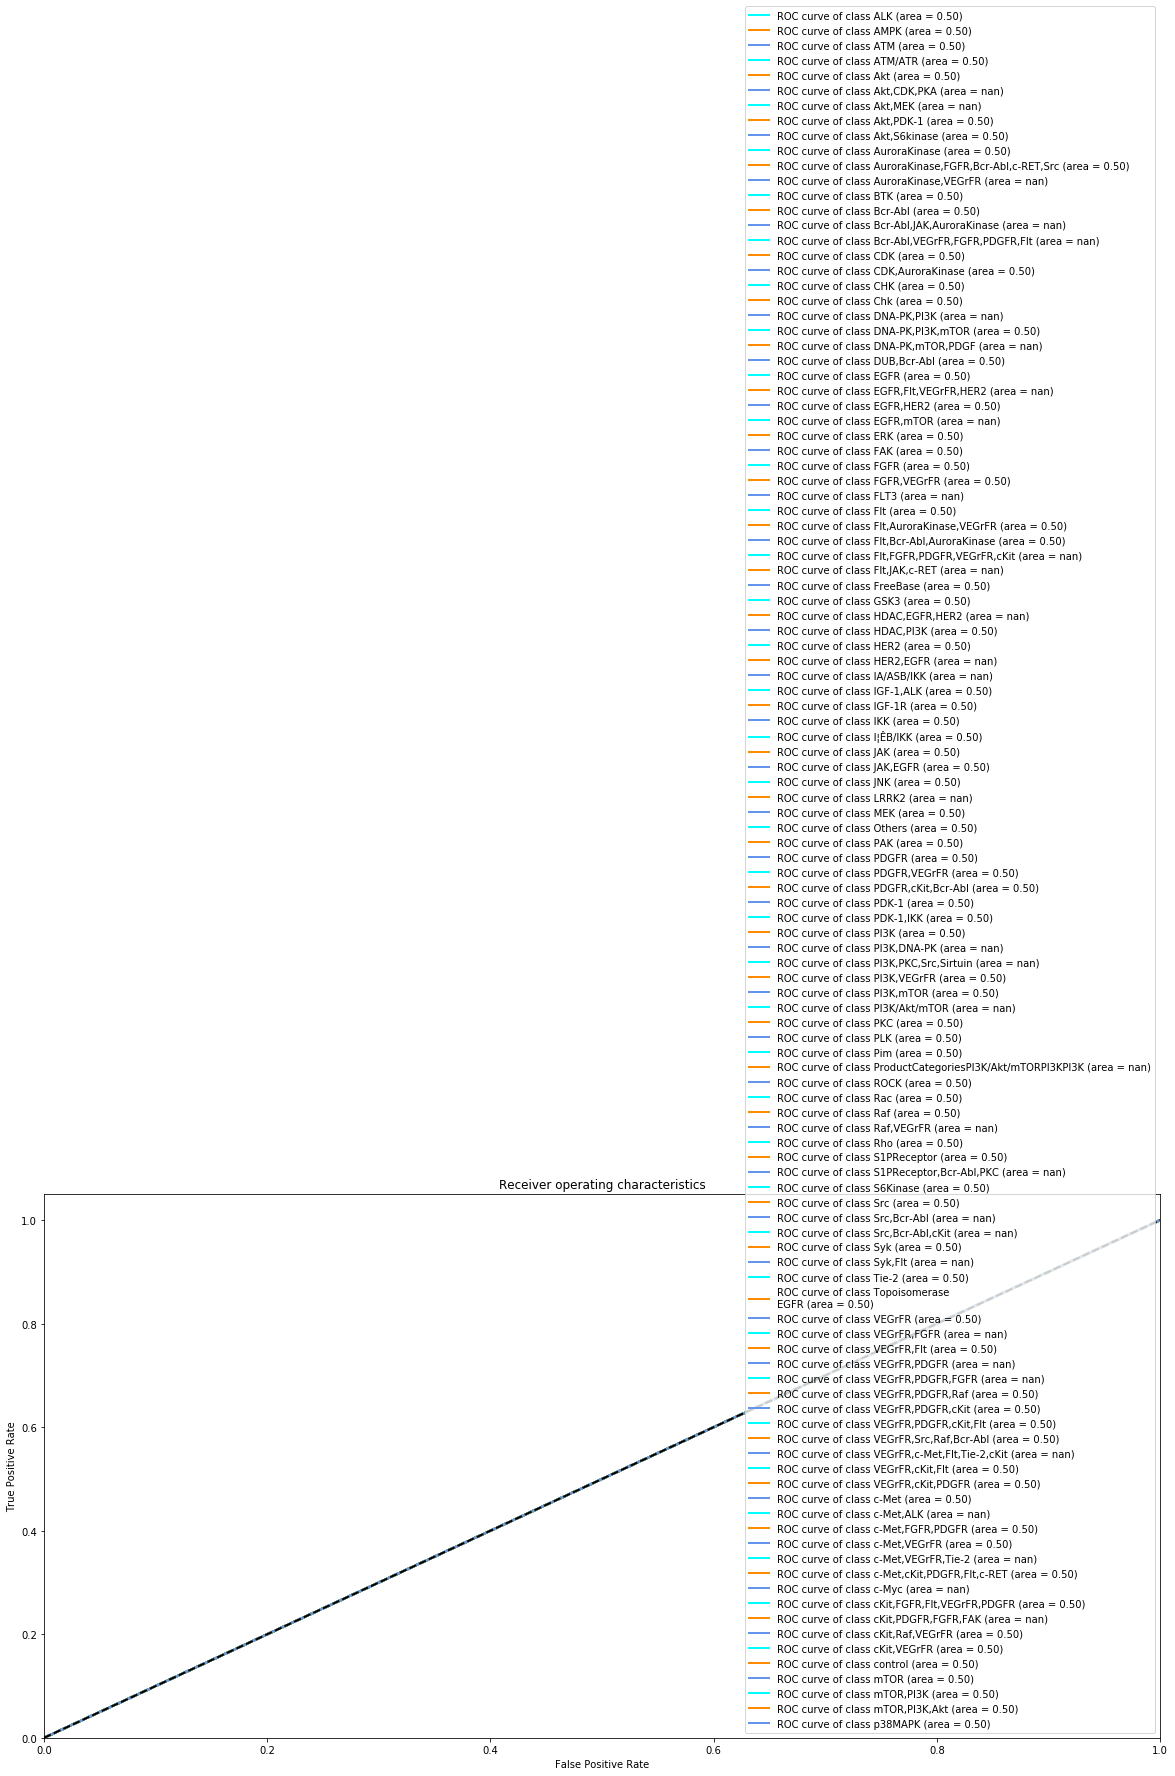

In [75]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(nrclasses)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(nrclasses):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= nrclasses

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.rcParams["figure.figsize"] = (20,10)
plt.figure()
# plt.plot(fpr["micro"], tpr["micro"],
#         label='micro-average ROC curve (area = {0:0.2f})'
#               ''.format(roc_auc["micro"]),
#         color='deeppink', linestyle=':', linewidth=4)

# plt.plot(fpr["macro"], tpr["macro"],
#          label='macro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["macro"]),
#          color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(nrclasses), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(activities[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics')
plt.legend(loc="lower right")
# plt.show()

plt.savefig('auc_roc.png', dpi=300)